### Run QG model to equilibrium and plot KE & PV

Spin up QG model and save equilibriated state. We will use `run_with_snapshots` and `get_diagnostic` to save the PV anomaly and mean eddy kinetic energy.

TODO: 
- encode parameters in a config file
- Notebooks:
    1. run a single ensemble member with a parameter for randomness and save data
    2. analysis that loads EMs


In [1]:
import numpy as np
import xarray as xr
import pyqg
from pyqg import diagnostic_tools as tools
from pyqg import qg_model, particles
import matplotlib.pyplot as plt
from numpy.random import Generator, MT19937
from numpy.random import RandomState, SeedSequence

#### Ensemble Member 1

In [2]:
# Set parameters & initialize model
year = 24*60*60*360.
twrite = 1000
tavestart = 2*year

# Initialize QG Model
m = pyqg.QGModel(tmax=20*year, twrite=twrite, tavestart=tavestart)

# Container for the BitGenerator with initialized random number generator
rg = Generator(MT19937(SeedSequence(123456789)))

# set upper and lower PV anomaly in spatial coordinates
sig = 1.e-6
qi = sig*np.vstack([rg.random((m.nx,m.ny))[np.newaxis,],
                  rg.random((m.nx,m.ny))[np.newaxis,]])

m.set_q(qi) 


INFO:  Logger initialized


In [3]:
def test_reproducible_generator():
    '''Test the random seed generator.'''
    rg = Generator(MT19937(SeedSequence(123456789)))
    rn1 = rg.random(10)
    
    rg = Generator(MT19937(SeedSequence(123456789)))
    rn2 = rg.random(10)
    
    print(rg)
    comparison = rn1 == rn2

    assert comparison.all(),"Random numbers in each set are different."
    
test_reproducible_generator()

Generator(MT19937)


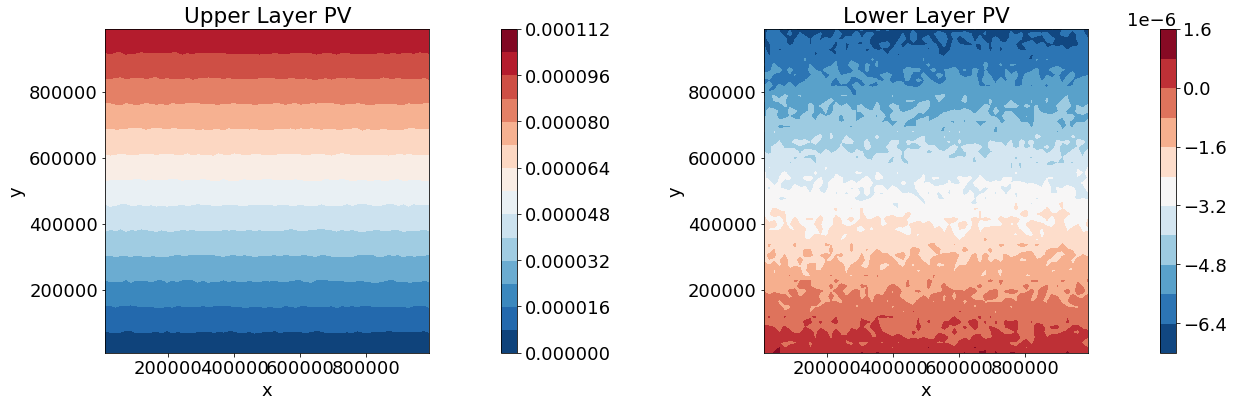

In [4]:
# Plot initialized PV on ensemble member 1
qi_upper = m.q[0] + m.Qy[0]*m.y
qi_lower = m.q[1] + m.Qy[1]*m.y

plt.figure(figsize=(18,6))
plt.rcParams.update({'font.size': 18})

plt.subplot(121)
plt.contourf(m.x, m.y, qi_upper, 12, cmap='RdBu_r')
plt.xlabel('x'); plt.ylabel('y'); plt.title('Upper Layer PV')
plt.colorbar(); plt.axis('square')

plt.subplot(122)
plt.contourf(m.x, m.y, qi_lower, 12, cmap='RdBu_r')
plt.xlabel('x'); plt.ylabel('y'); plt.title('Lower Layer PV')
plt.colorbar(); plt.axis('square')

plt.tight_layout();

### Run model to equilibrium


In [5]:
datasets = []

for snapshot in m.run_with_snapshots(tsnapstart=m.t, tsnapint=m.dt):
    model = m.to_dataset()
    model = model.assign(q=(('time','lev','y','x'), m.q.copy()[np.newaxis,...]))
    datasets.append(model)
    
  

INFO: Step: 1000, Time: 7.20e+06, KE: 4.19e-07, CFL: 0.014
INFO: Step: 2000, Time: 1.44e+07, KE: 6.96e-07, CFL: 0.013
INFO: Step: 3000, Time: 2.16e+07, KE: 1.39e-06, CFL: 0.014
INFO: Step: 4000, Time: 2.88e+07, KE: 3.15e-06, CFL: 0.015
INFO: Step: 5000, Time: 3.60e+07, KE: 7.67e-06, CFL: 0.017
INFO: Step: 6000, Time: 4.32e+07, KE: 1.94e-05, CFL: 0.019
INFO: Step: 7000, Time: 5.04e+07, KE: 4.90e-05, CFL: 0.028
INFO: Step: 8000, Time: 5.76e+07, KE: 1.15e-04, CFL: 0.046
INFO: Step: 9000, Time: 6.48e+07, KE: 2.08e-04, CFL: 0.065
INFO: Step: 10000, Time: 7.20e+07, KE: 2.61e-04, CFL: 0.068
INFO: Step: 11000, Time: 7.92e+07, KE: 3.16e-04, CFL: 0.076
INFO: Step: 12000, Time: 8.64e+07, KE: 3.88e-04, CFL: 0.078
INFO: Step: 13000, Time: 9.36e+07, KE: 4.09e-04, CFL: 0.078
INFO: Step: 14000, Time: 1.01e+08, KE: 4.38e-04, CFL: 0.095
INFO: Step: 15000, Time: 1.08e+08, KE: 4.49e-04, CFL: 0.089
INFO: Step: 16000, Time: 1.15e+08, KE: 4.66e-04, CFL: 0.086
INFO: Step: 17000, Time: 1.22e+08, KE: 4.95e-04, 

In [6]:
ds = xr.concat(datasets, dim='time')

#### Mean Eddy Kinetic Energy (EKE) as a function of time

model appears stable at 14.0 years


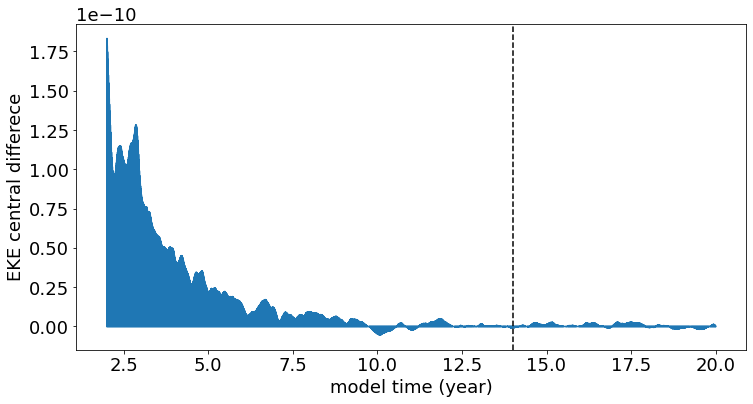

In [7]:
dEKE_dt = np.gradient(ds.EKE.isel(lev=0), ds.time)
I = int(np.where(np.abs(ds.time - year*14)==np.min(np.abs(ds.time - year*14)))[0])
time_stable = ds.time[I].values

# Plot EKE derivative
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12,6)); plt.plot(ds.time/year, dEKE_dt)
plt.ylabel('EKE central differece'); plt.xlabel('model time (year)')
plt.axvline(x=time_stable/year, color='k', linestyle='--')


print('model appears stable at', ds.time[I].values/year, 'years');

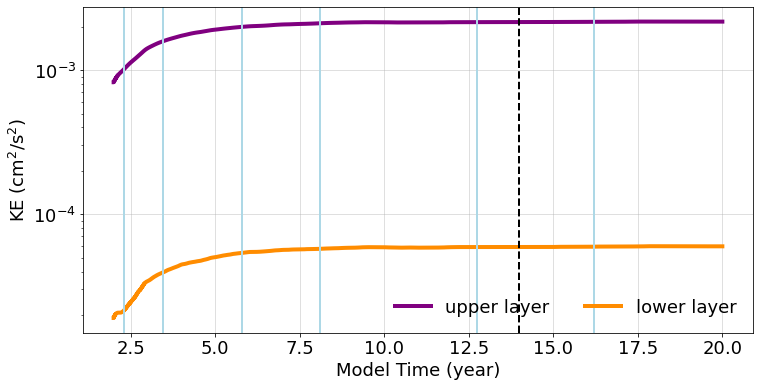

In [8]:
# Plot time series of EKE
plt.figure(figsize=(12,6))
plt.semilogy(ds.time/year, ds.EKE.isel(lev=0), lw=4, color='purple', label='upper layer')
plt.semilogy(ds.time/year, ds.EKE.isel(lev=1), lw=4, color='darkorange', label='lower layer')
ints = [10000, 15000, 25000, 35000, 55000, 70000]
for i in ints:
    plt.axvline(x=ds.time[i]/year, color='lightblue', linewidth=2, alpha=1)
plt.axvline(x=time_stable/year, color='k', lw=2, linestyle='--')
plt.grid(True, alpha=0.5); plt.legend(frameon=False, ncol=2)
plt.ylabel(r'KE ($\rmcm^{2}$/$\rms^{2}$)'); plt.xlabel('Model Time (year)');

As the model gets spun up, the mean EKE increases until it reaches an equilibrated state. When the EKE plateaus the model is in a stable state. The dashed vertical line marks 12.5 years when the model appears stable. This would be a good place to save the model state for the ensemble perturbation experiment.

Vertical light blue lines show times corresponding the the snapshots plotted below. 

### Evolution of the upper PV anomaly field

In [9]:
print('stable index ', int(np.where(ds.time == time_stable)[0]))

stable index  60479


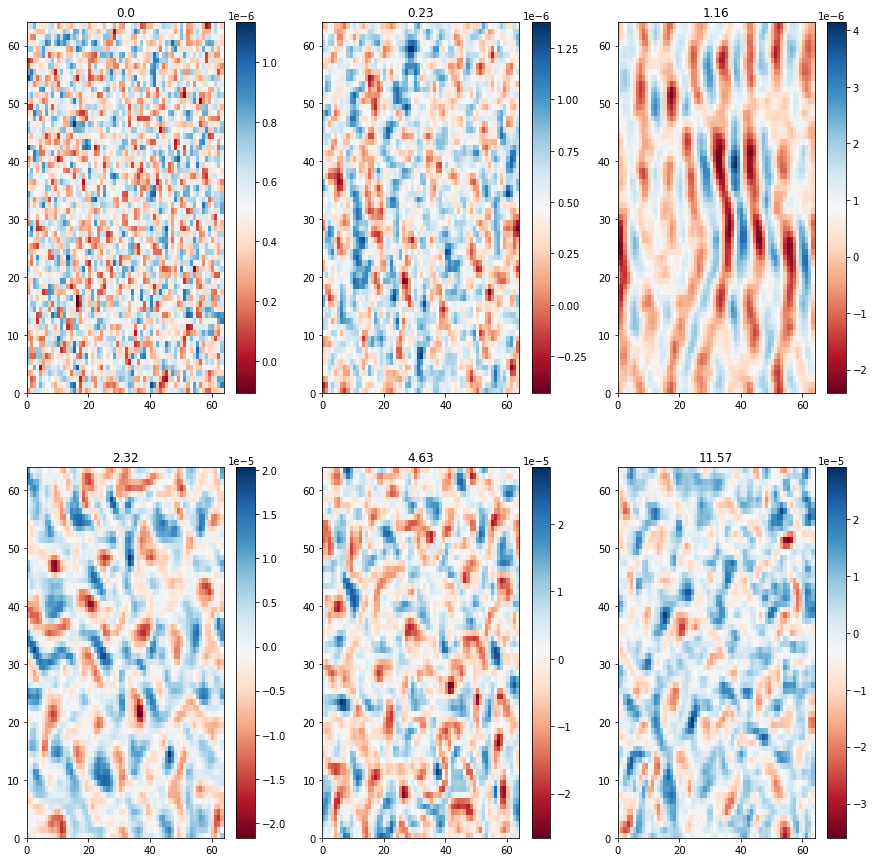

In [10]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['image.cmap'] = 'RdBu'

ints = [0, 1000, 5000, 10000, 20000, 50000]
plt.figure(figsize=(15,15))
for i in enumerate(ints):
    plt.subplot(2,3,i[0]+1)
    plt.pcolormesh(ds.q[i[1],0,:,:])
    plt.title((ds.time[i[1]].values/year).round(decimals=2), color='k')
    plt.colorbar()


The titles correspond to the model time in years. 

#### Save model state at equilibrium

In [14]:
I = int(np.where(np.abs(ds.time - time_stable)==np.min(np.abs(ds.time - time_stable)))[0])
qg_equilibrium = ds[dict(time=I)]


In [16]:
path = '/burg/abernathey/users/hillary/'
qg_equilibrium.to_netcdf(path+'QG_equilibrium_proto.nc', engine='h5netcdf', invalid_netcdf=True)